<a href="https://colab.research.google.com/github/ContiPaolo/Multifidelity-Tutorial/blob/main/MF_POD_Burger's1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Multi-fidelity reduced-order modeling on Groundwater's flow - Darcy equation**

As seen in the identification with the FOM model the nature of the problem poses a limitation on the accuracy of recontruction.
It is shown that any model with an accuracy higher that 0.01 will be masked by the noise and, more importantly, by the likelyhood. This is due to the need to explore a high dimentional space (n = 64)

We put ourself in the context of a FOM model that is extremely expensive. It would be therefore usefull to be able to retrieve the needed accuracy of the model using the least possibile training data. 

We aim to create a system with two levels of fidelity using 16000 data fine. 

The first level will be a Neural Network that, recieving as inputs the 64 coefficients of the trasmissivity field, tries to predict the 25 output values 

The second level of fidelity is intended as a refinement of the first model. Indeed it recieved as inputs the paramaters and the 25 coarse solution to predict the fine 25 solution 

#### (1) **Importing libraries and Loading data** 
#### (2) **Training of Coarse level surrogate model**
#### (3) **Generation of multi-fidelity dataset**
#### (4) **Training Fine level neural network surrogate model**
#### (5) **Evaluation of different models**



### 1 ) Libraries and Data 

In [24]:
import numpy as np
#import matplotlib as plt
from matplotlib import pyplot as plt
import pandas as pd 
from tensorflow.keras.optimizers import Adam,Nadam,Adamax
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.models import load_model
from keras.regularizers import l2
from sklearn.utils import extmath

#######################     CONFIGURATIONS     ##########################
seed = 29
train = True
save = True

Choose the number of data used to train the models

In [22]:
N_c = 20000

In [23]:
X_test = np.loadtxt("./data/X_test_coarse_32000.csv" , delimiter = ",")[:2000]
y_test = np.loadtxt("./data/y_test_coarse_32000.csv" , delimiter = ",")[:2000]

X_train =np.loadtxt("./data/X_train_coarse_32000.csv" , delimiter = ",")[:N_c]
y_train =np.loadtxt("./data/y_train_coarse_32000.csv" , delimiter = ",")[:N_c]

n_c = X_train.shape[1]
n_c

64

The dataset has been developed using fenics library, it is composed of 64000 samples divided in 90% training and 10% testing.\
The input (or X) are the 64 first component of the Karhunen-Loève (KL) decompositions. \
These eigenmodes allow to paratetrize a random field in the most accurate way.

The output: 25 sensors are used to record the hydraulic pressure in the domain $\Omega$ = [ 0 , 1 ] x [ 0 , 1 ]  \
The sensors are distributed on a grid with positions [0.1, 0.3, 0.5, 0.7, 0.9]



### 2 ) Training Fully connected neural network surrogate model

Let us try to create a map $T(x) \rightarrow u(x)$ 

Create a NN that takes in inuput the 64 eigenvalues of the transittivity field and returns the hydraulic pressure in the 25 points where the sensors are located 


In [50]:
Training = False

# Define the learning rate scheduler function
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return max(lr * 0.99, 5e-5)

# Initialize the neural network model
model_lf = Sequential()


# Add layers to the model

model_lf.add(Dense(64, input_shape=(n_c,), activation='gelu'))
model_lf.add(Dense(64, activation='gelu'))
model_lf.add(Dense(64, activation='sigmoid'))
model_lf.add(Dense(32, activation='sigmoid'))
model_lf.add(Dense(25, activation='exponential'))


if Training:
    # Compile the model
    initial_learning_rate = 0.001
    optimizer = Adam(learning_rate=initial_learning_rate)
    model_lf.compile(optimizer=optimizer, loss='mean_squared_error')

    # Define the learning rate scheduler callback
    lr_scheduler = LearningRateScheduler(scheduler)

    # Train the model
    history_lf = model_lf.fit(X_train, y_train, 
                    epochs=1500, 
                    batch_size=64, 
                    validation_data=(X_test, y_test),
                    callbacks=[lr_scheduler])
    
    model_lf.save('./models2/model_LF_20000_2.keras')

model_lf = load_model('./models2/model_LF_20000_2.keras')


/Users/lucacaroselli/miniconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [35]:
# Evaluate the model on the test set
test_loss = model_lf.evaluate(x=X_test, y=y_test)

# Print the test accuracy
print(f"Test accuracy: {test_loss}")
print(f"Test rmse: {np.sqrt(test_loss)}")

if Training:
    plt.plot(history_lf.history['loss'], label='Loss')
    plt.plot(history_lf.history['val_loss'], label='Val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate over Epochs')
    plt.legend()
    plt.show()



63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step - loss: 1.0536e-04
Test accuracy: 0.00010331796511309221
Test rmse: 0.010164544510852034


Se how it is able to prodict 

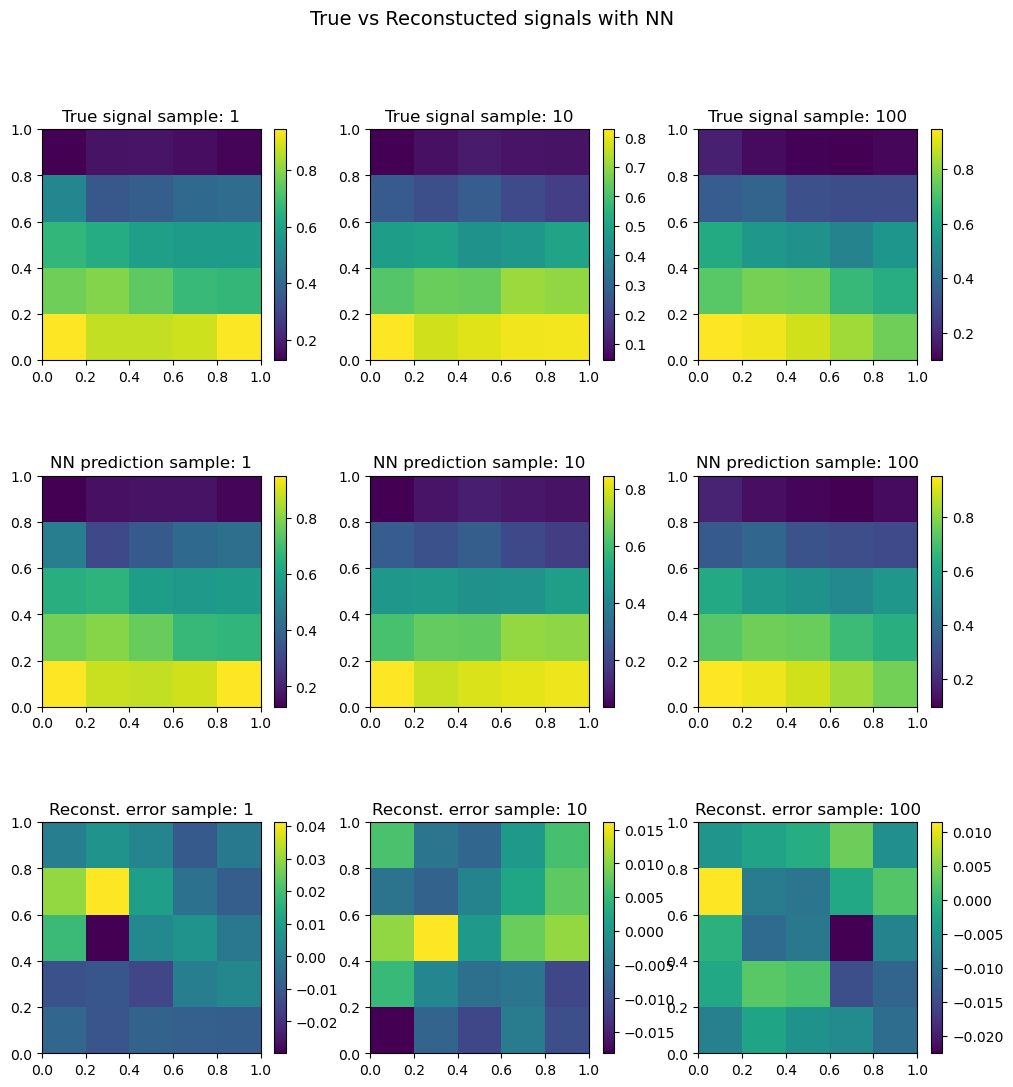

In [19]:
# Define the sampling points.
x_data = y_data = np.array([0.1, 0.3, 0.5, 0.7, 0.9])
# Grid to plot the basis 
X,Y = np.meshgrid(x_data, y_data)

samples = [ 1, 10, 100]
#Plot POD coefficients: LF vs HF
fig = plt.figure(figsize=(12,12))
plt.subplots_adjust(hspace=0.5)
title = 'True vs Reconstucted signals with NN'
fig.suptitle(title, fontsize=14)

for mode in range(3):
    ax = fig.add_subplot(331 + mode)
    pcm = plt.pcolormesh(X, Y, y_test[mode, :].reshape((5, 5)))
    ax.title.set_text('True signal sample: ' + str(samples[mode]))
    plt.colorbar(pcm, ax=ax)
    
    ax = fig.add_subplot(331 + mode + 3)
    reconstructed_sample = np.array(model_lf(X_test[mode, :].reshape((1, n_c)))).reshape((5, 5))
    err = y_test[mode, :].reshape(5, 5) - reconstructed_sample
    pcm = plt.pcolormesh(X, Y, reconstructed_sample.reshape((5, 5)))
    ax.title.set_text('NN prediction sample: ' + str(samples[mode]))
    plt.colorbar(pcm, ax=ax)
    
    ax = fig.add_subplot(331 + mode + 6)
    pcm = plt.pcolormesh(X, Y, err)
    ax.title.set_text('Reconst. error sample: ' + str(samples[mode]))
    plt.colorbar(pcm, ax=ax)


### 3 ) Generation of multi-fidelity datset

From now on we will only consider the best low fidelity model = Low fidelity 2

In [51]:
N_f = 10000

In [52]:
X_test_f = np.loadtxt("./data/X_test_64000.csv" , delimiter = ",")[:2000]
y_test_f = np.loadtxt("./data/y_test_64000.csv" , delimiter = ",")[:2000]

X_train_f =np.loadtxt("./data/X_train_64000.csv" , delimiter = ",")[:N_f]
y_train_f =np.loadtxt("./data/y_train_64000.csv" , delimiter = ",")[:N_f]

In [71]:
Training = True 
if Training:
    coarse_sol = np.zeros((N_f, 25))
    for i in range(N_f):
        coarse_sol[i,:] = model_lf(X_train_f[i,:].reshape((1,64)))
    
    coarse_sol_test = np.zeros((2000,25))
    for i in range(2000):
        coarse_sol_test[i,:] = model_lf(X_test_f[i,:].reshape((1,64)))
    np.savetxt('./data/coarse_sol_training2.csv', coarse_sol, delimiter=',' )
    np.savetxt('./data/coarse_sol_test2.csv', coarse_sol_test, delimiter=',' )

else: 
    coarse_sol = np.loadtxt('./data/coarse_sol_training2.csv', delimiter=',')
    coarse_sol_test = np.loadtxt('./data/coarse_sol_test2.csv', delimiter=',')
    

In [72]:
X_train2 = np.hstack((X_train_f, coarse_sol))
X_test2 = np.hstack((X_test_f, coarse_sol_test))

### 4 ) Training Fine-level NN surrogate 

In [75]:
n_f = X_train2.shape[1]
n_f

89

In [81]:
Training = True


# Define the learning rate scheduler function
def scheduler(epoch, lr):
    if epoch < 20:
        return lr
    else:
        return max(lr * 0.99, 5e-5)

# Initialize the neural network model
model_hf = Sequential()

# Add layers to the model
model_hf.add(Dense(128, input_shape=(n_f,), activation='gelu'))
model_hf.add(Dense(128, activation='gelu'))
model_hf.add(Dense(128, activation='sigmoid'))
model_hf.add(Dense(128, activation='sigmoid'))
#model_hf.add(Dense(128, activation='sigmoid'))
model_hf.add(Dense(25, activation='exponential'))


if Training:
    # Compile the model
    initial_learning_rate = 0.001
    optimizer = Adam(learning_rate=initial_learning_rate)
    model_hf.compile(optimizer=optimizer, loss='mean_squared_error')

    # Define the learning rate scheduler callback
    lr_scheduler = LearningRateScheduler(scheduler)

    # Train the model
    history_hf = model_hf.fit(X_train2, y_train_f, 
                    epochs=1500, 
                    batch_size=64, 
                    validation_data=(X_test2, y_test_f),
                    callbacks=[lr_scheduler])
    
    model_hf.save('./models2/model_HF_10000_4.keras')

model_hf = load_model('./models2/model_HF_10000_4.keras')

Epoch 1/1500
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1113 - val_loss: 0.0056 - learning_rate: 0.0010
Epoch 2/1500
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0048 - val_loss: 0.0030 - learning_rate: 0.0010
Epoch 3/1500
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0027 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 4/1500
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0019 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 5/1500
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0016 - val_loss: 0.0014 - learning_rate: 0.0010
Epoch 6/1500
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0013 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 7/1500
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0012 - val_loss: 0.0011 - learning_rate: 0.0010
Epoch 8/1500
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0010 - val_loss: 0.0010 - learning_rate: 0.0010
Epoch 9/1500
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.2648e-04 - val_loss: 9.2409e-04 - learni

In [85]:
# Evaluate the model on the test set
test_loss = model_hf.evaluate(x=X_test2, y=y_test_f)

# Print the test accuracy
print(f"Test accuracy: {test_loss}")
print(f"Test rmse: {np.sqrt(test_loss)}")

if Training:
    plt.plot(history_hf.history['loss'], label='Loss')
    plt.plot(history_hf.history['val_loss'], label='Val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate over Epochs')
    plt.legend()
    plt.show()


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 6.5688e-05
Test accuracy: 6.492153625003994e-05
Test rmse: 0.008057390163696923


### 5 ) Evaluation of different models 

#### LOW FIDELITY MODELS 

MODEL LF 1 

In [36]:
model_lf = Sequential()

# Add layers to the model
model_lf.add(Dense(64, input_shape=(n_c,), activation='gelu'))
model_lf.add(Dense(64, activation='gelu'))
model_lf.add(Dense(64, activation='gelu'))
model_lf.add(Dense(32, activation='gelu'))
model_lf.add(Dense(25, activation='exponential'))

model_lf = load_model('./models2/model_LF_20000_1.keras')

In [37]:
# Evaluate the model on the test set
training_loss = model_lf.evaluate(x=X_train, y=y_train)
test_loss = model_lf.evaluate(x=X_test, y=y_test)

# Print the test accuracy
print(f"Training accuracy: {training_loss}")
print(f"Test accuracy: {test_loss}")
print(f"Test rmse: {np.sqrt(test_loss)}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step - loss: 8.8789e-05
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step - loss: 1.0536e-04
Training accuracy: 8.865338895702735e-05
Test accuracy: 0.00010331796511309221
Test rmse: 0.010164544510852034


MODEL LF 2 

In [38]:
model_lf = Sequential()

# Add layers to the model
model_lf.add(Dense(128, input_shape=(n_c,), activation='gelu'))
model_lf.add(Dense(32, activation='gelu'))
model_lf.add(Dense(25, activation='exponential'))

model_lf = load_model('./models2/model_LF_20000_2.keras')

In [39]:
# Evaluate the model on the test set
training_loss = model_lf.evaluate(x=X_train, y=y_train)
test_loss = model_lf.evaluate(x=X_test, y=y_test)

# Print the test accuracy
print(f"Training accuracy: {training_loss}")
print(f"Test accuracy: {test_loss}")
print(f"Test rmse: {np.sqrt(test_loss)}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step - loss: 7.6902e-05
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - loss: 9.6502e-05
Training accuracy: 7.636886584805325e-05
Test accuracy: 9.426909673493356e-05
Test rmse: 0.009709227401546096


MODEL LF 3

In [40]:
model_lf = Sequential()

# Add layers to the model
model_lf.add(Dense(64, input_shape=(n_c,), activation='gelu'))
model_lf.add(Dense(64, activation='gelu'))
model_lf.add(Dense(64, activation='sigmoid'))
model_lf.add(Dense(32, activation='sigmoid'))
model_lf.add(Dense(25, activation='exponential'))

model_lf = load_model('./models2/model_LF_20000_3.keras')

In [41]:
# Evaluate the model on the test set
training_loss = model_lf.evaluate(x=X_train, y=y_train)
test_loss = model_lf.evaluate(x=X_test, y=y_test)

# Print the test accuracy
print(f"Training accuracy: {training_loss}")
print(f"Test accuracy: {test_loss}")
print(f"Test rmse: {np.sqrt(test_loss)}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step - loss: 1.0813e-04
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step - loss: 1.2543e-04
Training accuracy: 0.000106691790279001
Test accuracy: 0.00012393121141940355
Test rmse: 0.011132439598731428


MODEL LF 4

In [42]:
model_lf = Sequential()

# Add layers to the model
model_lf.add(Dense(128, input_shape=(n_c,), activation='sigmoid'))
model_lf.add(Dense(32, activation='sigmoid'))
model_lf.add(Dense(25, activation='exponential'))

model_lf = load_model('./models2/model_LF_20000_4.keras')

In [43]:
# Evaluate the model on the test set
training_loss = model_lf.evaluate(x=X_train, y=y_train)
test_loss = model_lf.evaluate(x=X_test, y=y_test)

# Print the test accuracy
print(f"Training accuracy: {training_loss}")
print(f"Test accuracy: {test_loss}")
print(f"Test rmse: {np.sqrt(test_loss)}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step - loss: 1.1529e-04
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step - loss: 1.3978e-04
Training accuracy: 0.00011442756658652797
Test accuracy: 0.00013789217337034643
Test rmse: 0.011742749821500347


MODEL LF 5

In [44]:
model_lf = Sequential()

# Add layers to the model
model_lf.add(Dense(64, input_shape=(n_c,), activation='tanh'))
model_lf.add(Dense(64, activation='tanh'))
model_lf.add(Dense(64, activation='tanh'))
model_lf.add(Dense(32, activation='tanh'))
model_lf.add(Dense(25, activation='exponential'))

model_lf = load_model('./models2/model_LF_20000_5.keras')

In [45]:
# Evaluate the model on the test set
training_loss = model_lf.evaluate(x=X_train, y=y_train)
test_loss = model_lf.evaluate(x=X_test, y=y_test)

# Print the test accuracy
print(f"Training accuracy: {training_loss}")
print(f"Test accuracy: {test_loss}")
print(f"Test rmse: {np.sqrt(test_loss)}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step - loss: 1.0666e-04
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step - loss: 1.2530e-04
Training accuracy: 0.00010532289888942614
Test accuracy: 0.00012537431030068547
Test rmse: 0.01119706704010856


MODEL LF 6

In [46]:
model_lf = Sequential()

# Add layers to the model
model_lf.add(Dense(128, input_shape=(n_c,), activation='tanh'))
model_lf.add(Dense(32, activation='tanh'))
model_lf.add(Dense(25, activation='exponential'))

model_lf = load_model('./models2/model_LF_20000_6.keras')

In [47]:
# Evaluate the model on the test set
training_loss = model_lf.evaluate(x=X_train, y=y_train)
test_loss = model_lf.evaluate(x=X_test, y=y_test)

# Print the test accuracy
print(f"Training accuracy: {training_loss}")
print(f"Test accuracy: {test_loss}")
print(f"Test rmse: {np.sqrt(test_loss)}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step - loss: 8.1384e-05
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step - loss: 9.8105e-05
Training accuracy: 8.083967259153724e-05
Test accuracy: 9.838914411375299e-05
Test rmse: 0.009919130209537174


#### HIGH-FIDELITY MODELS

HF MODEL 1 

In [82]:
model_hf = Sequential()

model_hf.add(Dense(256, input_shape=(n_f,), activation='gelu'))
model_hf.add(Dense(128, activation='gelu'))
model_hf.add(Dense(64, activation='gelu'))
model_hf.add(Dense(25, activation='exponential'))

model_hf = load_model('./models2/model_HF_10000_1.keras')

In [83]:
# Evaluate the model on the test set
training_loss = model_hf.evaluate(x=X_train2, y=y_train_f)
test_loss = model_hf.evaluate(x=X_test2, y=y_test_f)

# Print the test accuracy
print(f"Training accuracy: {training_loss}")
print(f"Test accuracy: {test_loss}")
print(f"Test rmse: {np.sqrt(test_loss)}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 1.5807e-05
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 6.6935e-05
Training accuracy: 1.570426502439659e-05
Test accuracy: 6.657352059846744e-05
Test rmse: 0.008159259807020943


HF MODEL 2

In [84]:
model_hf = Sequential()

model_hf.add(Dense(128, input_shape=(n_f,), activation='gelu'))
model_hf.add(Dense(128, activation='gelu'))
model_hf.add(Dense(128, activation='gelu'))
model_hf.add(Dense(128, activation='gelu'))
model_hf.add(Dense(25, activation='exponential'))

model_hf = load_model('./models2/model_HF_10000_2.keras')

In [85]:
# Evaluate the model on the test set
training_loss = model_hf.evaluate(x=X_train2, y=y_train_f)
test_loss = model_hf.evaluate(x=X_test2, y=y_test_f)

# Print the test accuracy
print(f"Training accuracy: {training_loss}")
print(f"Test accuracy: {test_loss}")
print(f"Test rmse: {np.sqrt(test_loss)}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 2.6294e-05
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step - loss: 7.2768e-05
Training accuracy: 2.6203328161500394e-05
Test accuracy: 7.10481617716141e-05
Test rmse: 0.008429007164050468


MODEL HF 3

In [86]:
model_hf = Sequential()

model_hf.add(Dense(256, input_shape=(n_f,), activation='sigmoid'))
model_hf.add(Dense(128, activation='sigmoid'))
model_hf.add(Dense(64, activation='sigmoid'))
model_hf.add(Dense(25, activation='exponential'))

model_hf = load_model('./models2/model_HF_10000_3.keras')

In [87]:
# Evaluate the model on the test set
training_loss = model_hf.evaluate(x=X_train2, y=y_train_f)
test_loss = model_hf.evaluate(x=X_test2, y=y_test_f)

# Print the test accuracy
print(f"Training accuracy: {training_loss}")
print(f"Test accuracy: {test_loss}")
print(f"Test rmse: {np.sqrt(test_loss)}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step - loss: 4.5821e-05
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step - loss: 1.1261e-04
Training accuracy: 4.605853246175684e-05
Test accuracy: 0.00011159319547004998
Test rmse: 0.01056376805264343


MODEL HF 4

In [88]:
model_hf = Sequential()

model_hf.add(Dense(128, input_shape=(n_f,), activation='gelu'))
model_hf.add(Dense(128, activation='gelu'))
model_hf.add(Dense(128, activation='sigmoid'))
model_hf.add(Dense(128, activation='sigmoid'))
model_hf.add(Dense(25, activation='exponential'))

model_hf = load_model('./models2/model_HF_10000_4.keras')

In [89]:
# Evaluate the model on the test set
training_loss = model_hf.evaluate(x=X_train2, y=y_train_f)
test_loss = model_hf.evaluate(x=X_test2, y=y_test_f)

# Print the test accuracy
print(f"Training accuracy: {training_loss}")
print(f"Test accuracy: {test_loss}")
print(f"Test rmse: {np.sqrt(test_loss)}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step - loss: 3.6509e-05
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step - loss: 8.3082e-05
Training accuracy: 3.6445340811042115e-05
Test accuracy: 8.132493530865759e-05
Test rmse: 0.009018033893740784


MODEL HF 5

In [90]:
model_hf = Sequential()

model_hf.add(Dense(256, input_shape=(n_f,), activation='tanh'))
model_hf.add(Dense(128, activation='tanh'))
model_hf.add(Dense(64, activation='tanh'))
model_hf.add(Dense(25, activation='exponential'))

model_hf = load_model('./models2/model_HF_10000_5.keras')

In [92]:
# Evaluate the model on the test set
training_loss = model_hf.evaluate(x=X_train2, y=y_train_f)
test_loss = model_hf.evaluate(x=X_test2, y=y_test_f)

# Print the test accuracy
print(f"Training accuracy: {training_loss}")
print(f"Test accuracy: {test_loss}")
print(f"Test rmse: {np.sqrt(test_loss)}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step - loss: 3.0644e-05
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 9.5726e-05
Training accuracy: 3.0602419428760186e-05
Test accuracy: 9.235160541720688e-05
Test rmse: 0.009609974267249985


MODEL HF 6

In [93]:
model_hf = Sequential()

model_hf.add(Dense(128, input_shape=(n_f,), activation='tanh'))
model_hf.add(Dense(128, activation='tanh'))
model_hf.add(Dense(128, activation='tanh'))
model_hf.add(Dense(128, activation='tanh'))
model_hf.add(Dense(25, activation='exponential'))

model_hf = load_model('./models2/model_HF_10000_6.keras')

/Users/lucacaroselli/miniconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [94]:
# Evaluate the model on the test set
training_loss = model_hf.evaluate(x=X_train2, y=y_train_f)
test_loss = model_hf.evaluate(x=X_test2, y=y_test_f)

# Print the test accuracy
print(f"Training accuracy: {training_loss}")
print(f"Test accuracy: {test_loss}")
print(f"Test rmse: {np.sqrt(test_loss)}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step - loss: 4.2619e-05
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step - loss: 9.2118e-05
Training accuracy: 4.304098547436297e-05
Test accuracy: 9.004707681015134e-05
Test rmse: 0.009489313821881503


# BONUS 

This model would be too big to be used as a low fidelity model yet was calculataed to set a benchmark for the performane of larger Networks. 

To be more specific this model will help highlight the contribution that the knowledge on the POD coefficient give to the same Neural Network (model_POD_1)

In [64]:
model = Sequential()

# Add layers to the model
model.add(Dense(256, input_shape=(n_c,), activation='gelu'))
model.add(Dense(256, activation='gelu'))
model.add(Dense(256, activation='gelu'))
model.add(Dense(25, activation='exponential'))

model = load_model('./models/model_LF_64000_4.keras')

In [65]:
# Evaluate the model on the test set
training_loss = model.evaluate(x=X_train, y=y_train)
test_loss = model.evaluate(x=X_test, y=y_test)

# Print the test accuracy
print(f"Training accuracy: {training_loss}")
print(f"Test accuracy: {test_loss}")
print(f"Test rmse: {np.sqrt(test_loss)}")


1800/1800 ━━━━━━━━━━━━━━━━━━━━ 1s 732us/step - loss: 1.3567e-05
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - loss: 1.3916e-05
Training accuracy: 1.3542909982788842e-05
Test accuracy: 1.3684657460544258e-05
Test rmse: 0.0036992779647580225
